# LAB 9: Feed-forward networks

**Objectives:**
- experiment with various simple neural architectures

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torchtext

tqdm.pandas()

Install some packages that aren't part of standard colab

In [2]:
!pip install -q portalocker cytoolz skorch transformers torchtext

---

## Load data

In [3]:
from torchtext.datasets import YelpReviewPolarity
from sklearn.utils import resample

In [4]:
import portalocker
import torchtext

In [5]:
def make_df(examples):
  rows = [{'label':label, 'text':text} for (label,text) in examples]
  return pd.DataFrame(rows)

In [6]:
train = make_df(YelpReviewPolarity(split='train'))
test = make_df(YelpReviewPolarity(split='test'))

In [7]:
train

,label,text
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...
...,...,...
559995,2,Ryan was as good as everyone on yelp has claim...
559996,2,Professional \nFriendly\nOn time AND affordabl...
559997,1,Phone calls always go to voicemail and message...
559998,1,Looks like all of the good reviews have gone t...


In [9]:
train = resample(train, replace=False, n_samples=150000, stratify=train["label"], random_state=42)

In [10]:
import spacy

nlp = spacy.load(
    "en_core_web_sm",
    exclude=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"],
)


def tokenize(text):
    doc = nlp.tokenizer(text)
    return [t.norm_ for t in doc if not (t.is_space or t.is_punct or t.like_num)]

train["tokens"] = train["text"].progress_apply(tokenize)
test["tokens"] = test["text"].progress_apply(tokenize)

100%|██████████| 38000/38000 [00:14<00:00, 2544.24it/s]


---

## Scikit-learn 

Try using scikit-learn's SGDClassifier. Skorch sets aside 20% of the training data for validation, so to make things more directly comparable we'll do the same here.

In [11]:
from cytoolz import identity
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats.distributions import loguniform, uniform

In [12]:
vectorizer = CountVectorizer(analyzer=identity)
sgd_train, _ = train_test_split(train, test_size=0.2)
X_train = vectorizer.fit_transform(sgd_train['tokens'])
X_test =  vectorizer.transform(test['tokens'])

y_train = sgd_train["label"]
y_test = test["label"]

In [13]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
sgd_predicted = sgd.predict(X_test)
print(accuracy_score(y_test, sgd_predicted))

0.9197894736842105


In [15]:
search = GridSearchCV(sgd, param_grid={'alpha':[1e-5,1e-4,1e-3]}, n_jobs=-1)
search.fit(X_train, y_train)
search.best_params_
# Best Alpha when 'alpha':[1e-6,1e-4,1e-2,1] is 0.0001
# Adjusting the 'alpha':[1e-5,1e-4,1e-3] range, best is 0.001

{'alpha': 0.001}

In [16]:
sgd.set_params(**search.best_params_)
sgd.fit(X_train, y_train)
sgd_predicted = sgd.predict(X_test)
print(accuracy_score(y_test, sgd_predicted))

0.9222894736842105


----

## Data prepartion

The input to scikit-learn classifiers has always been a document-term matrix (usually created by `CountVectorizer`). The input to a torch classifier should be a list of token ids. This will give us more flexibility in how the classifier represents the text. 

But, there's a complication: both torch and sklearn expect all document vectors to be the same length. That's easy for a document-term matrix, since the dimensionality of each document vector is the vocabulary size. If we're representing individual tokens, though, the length of the document vectors is equal to the length of the document, which won't be the same from doc to doc. 

To make all the doc lengths equal, we can add dummy words (`<pad>`) to end the of short texts. This will make all the docs as long as the longest doc in the dataset. Given the way doc lengths are distributed, though, very long texts are unusual all we'll be doing a lot of extra padding. 

A compromise is to cut off very long docs and pad out short ones so they all docs end up being of medium length.

In [17]:
import torch
import torchtext
import torch.nn.functional as F
from torch import nn, optim
from torchtext.transforms import VocabTransform, ToTensor, Truncate

Doc lengths range up to about 1,000 words but most are < 300 words.

<Axes: ylabel='Frequency'>

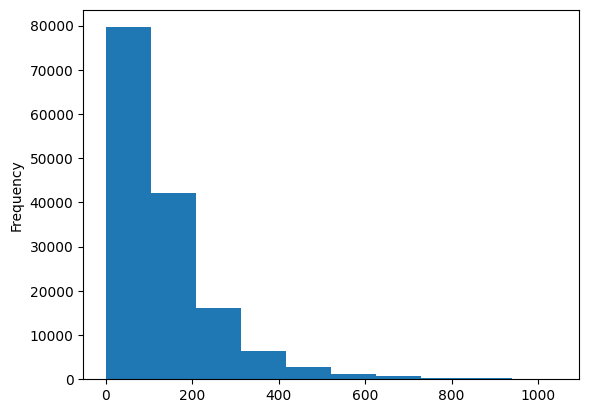

In [18]:
train['tokens'].apply(len).plot(kind='hist')

In [19]:
vocab = torchtext.vocab.build_vocab_from_iterator(train['tokens'], specials=['<pad>','<unk>'], min_freq=1)
vocab.set_default_index(vocab.get_stoi()['<unk>'])

PAD_IDX = vocab.get_stoi()['<pad>']

with torch.no_grad():
  tr = nn.Sequential(VocabTransform(vocab), Truncate(300), ToTensor(padding_value=PAD_IDX))

  X_train = tr(list(train['tokens'])).to('cuda')
  X_test = tr(list(test['tokens'])).to('cuda')

  y_train = train["label"].to_numpy(dtype=np.float32) - 1
  y_test = test["label"].to_numpy(dtype=np.float32) - 1


/usr/local/lib/python3.9/dist-packages/torch/_jit_internal.py:1297: UserWarning: The inner type of a container is lost when calling torch.jit.isinstance in eager mode. For example, List[int] would become list and therefore falsely return True for List[float] or List[str].
  warnings.warn(


---

## Embedding + one layer

This model is structurally a lot like `TruncatedSVD` + `SGDClassifier`. The big difference, though, is that it's trained as a single unit so that the dimensionality reduction step optimizies classification accuracy.

In [20]:
from skorch import NeuralNetBinaryClassifier

Define a simple 'bag of embeddings' model

$$
\mathbf{x}=\textrm{mean}\left(\mathbf{e}(w_1),\mathbf{e}(w_2),\ldots,\mathbf{e}(w_n)\right)$$
$$\mathbf{y}=\sigma\left(\mathbf{Wx}\right)$$

Some things to try:
- change size of embedding (`embedding_size`) and pooling mode (`pooling`). See documentation at https://pytorch.org/docs/stable/generated/torch.nn.EmbeddingBag.html#embeddingbag
- change `optimizer__weight_decay` (similar to to `alpha` for `SGDClassifier`)
- change `min_freq` in vocabulary

In [22]:
class EmbeddingLogisticR(nn.Module):
    def __init__(self, vocab_size, embedding_size, pooling, padding_idx):
        super().__init__()

        self.embedding = nn.EmbeddingBag(vocab_size, embedding_size, padding_idx=padding_idx, mode=pooling)
        self.output = nn.Linear(embedding_size, 1)

    def forward(self, X, **kwargs):
        e = self.embedding(X)
        y = self.output(e)
        return y

In [23]:
net = NeuralNetBinaryClassifier(
    EmbeddingLogisticR,
    module__vocab_size = len(vocab),
    module__embedding_size = 42, #
    module__pooling = "sum", #
    module__padding_idx = PAD_IDX,
    max_epochs = 10,
    verbose = 1,
    device = "cuda",
    optimizer = optim.Adam,
    batch_size = 1024,
    optimizer__weight_decay = 0.001 #
)

In [24]:
net.fit(X_train, y_train)
net_predicted = net.predict(X_test)
print(accuracy_score(y_test, net_predicted))

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7091       0.8353        0.3969  4.5937
      2        0.3364       0.8910        0.2919  2.5931
      3        0.2806       0.8963        0.2743  2.0554
      4        0.2695       0.8961        0.2729  1.9567
      5        0.2639       0.8976        0.2688  2.7507
      6        0.2610       0.8984        0.2657  1.9406
      7        0.2587       0.8995        0.2618  2.0143
      8        0.2567       0.9016        0.2562  2.5903
      9        0.2548       0.9042        0.2506  2.8482
     10        0.2530       0.9060        0.2477  1.9804
0.9086842105263158


In [26]:
net.set_params(verbose=0, max_epochs=5)
search = GridSearchCV(net, 
                      param_grid={'optimizer__weight_decay':[1e-6, 1e-5, 1e-4, 1e-3,1e-2, 1]}, 
                      verbose=2, refit=False, cv=2)
search.fit(X_train, y_train)
search.best_params_

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] END ......................optimizer__weight_decay=1e-06; total time=   6.7s
[CV] END ......................optimizer__weight_decay=1e-06; total time=   7.5s
[CV] END ......................optimizer__weight_decay=1e-05; total time=   6.6s
[CV] END ......................optimizer__weight_decay=1e-05; total time=   6.6s
[CV] END .....................optimizer__weight_decay=0.0001; total time=   6.5s
[CV] END .....................optimizer__weight_decay=0.0001; total time=   7.4s
[CV] END ......................optimizer__weight_decay=0.001; total time=   6.5s
[CV] END ......................optimizer__weight_decay=0.001; total time=   7.4s
[CV] END .......................optimizer__weight_decay=0.01; total time=   5.8s
[CV] END .......................optimizer__weight_decay=0.01; total time=   8.3s
[CV] END ..........................optimizer__weight_decay=1; total time=   6.6s
[CV] END ..........................optimizer__wei

{'optimizer__weight_decay': 1e-05}

In [28]:
search.best_score_

0.9143

In [27]:
net.set_params(verbose=1, **search.best_params_)
net.fit(X_train, y_train)
net_predicted = net.predict(X_test)
print(accuracy_score(y_test, net_predicted))

Re-initializing module because the following parameters were re-set: embedding_size, padding_idx, pooling, vocab_size.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6616       0.8318        0.3966  2.3023
      2        0.3386       0.8912        0.2866  1.9601
      3        0.2761       0.9002        0.2645  2.6940
      4        0.2626       0.9023        0.2569  1.9257
      5        0.2546       0.9042        0.2513  1.9337
0.9065


*Accuracy for test data, has dropped a tiny bit less than before, but less than the linear SGD model in both cases.*

---

## Deeper learning

Next, we'll add more hidden layers and apply dropout. The model equations are

$$\mathbf{x}=\textrm{mean}\left(\mathbf{e}(w_1),\mathbf{e}(w_2),\ldots,\mathbf{e}(w_n)\right)$$
$$\mathbf{h}_1=\sigma(\mathbf{Wx})$$
$$\mathbf{h}_2=\sigma(\mathbf{U}_2\mathbf{h}_1)$$
$$\mathbf{y}=\sigma\left(\mathbf{h}_2\right)$$

Additional things to try:
- Change the non-linearity used in the hidden layers `non_lin` (tanh, relu, etc). See documentation at https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions
- Change size of hidden layers `hidden_units`
- Add additional hidden layers
- Change dropout probability `dropout`


In [30]:
class EmbeddingMultilayer(nn.Module):
    def __init__(self, vocab_size, embedding_size, pooling, padding_idx, non_lin, hidden_units, dropout):
        super().__init__()

        self.non_lin = non_lin
        self.embedding = nn.EmbeddingBag(vocab_size, embedding_size, padding_idx=padding_idx, mode=pooling)
        self.hidden1 = nn.Linear(embedding_size, hidden_units)
        self.hidden2 = nn.Linear(hidden_units, hidden_units)
        self.output = nn.Linear(hidden_units, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X, **kwargs):
        e = self.embedding(X)
        e = self.dropout(e)
        h = self.non_lin(self.hidden1(e))
        h = self.dropout(h)
        h = self.non_lin(self.hidden2(h))
        h = self.dropout(h)
        y = self.output(h)
        return y

In [31]:
net = NeuralNetBinaryClassifier(
    EmbeddingMultilayer,
    module__vocab_size = len(vocab),
    module__embedding_size = 32,
    module__pooling = "mean",
    module__padding_idx = PAD_IDX,
    module__non_lin = F.tanh, #
    module__hidden_units = 45, #
    module__dropout = 0.4, #
    max_epochs = 10,
    verbose = 1,
    device = "cuda",
    batch_size = 1024,
    optimizer = optim.Adam,
    optimizer__weight_decay = 0,
    iterator_train__shuffle = True
)

In [32]:
net.fit(X_train, y_train)
net_predicted = net.predict(X_test)
print(accuracy_score(y_test, net_predicted))

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4003       0.9074        0.2375  1.9025
      2        0.2398       0.9196        0.2090  2.6395
      3        0.1964       0.9238        0.2009  1.8519
      4        0.1716       0.9256        0.1953  1.8082
      5        0.1515       0.9259        0.1969  2.3490
      6        0.1389       0.9243        0.2086  2.9978
      7        0.1254       0.9238        0.2174  1.8100
      8        0.1140       0.9229        0.2318  2.1771
      9        0.1052       0.9217        0.2396  1.7806
     10        0.0956       0.9201        0.2505  2.5816
0.9211315789473684


*Now the accuracy has neared the linear model*

---

## Pre-trained vectors

This model is the same as the one above, except it uses pre-trained GloVe vectors

Things to try:
- Different GloVe models (6B, twitter.27B, 42B, 840B) and dimensions; see https://nlp.stanford.edu/projects/glove/
- Change setting of `freeze` to allow fine-tuning

In [33]:
from torchtext.vocab import GloVe

In [35]:
glove = GloVe(name='twitter.27B', dim=100) #Changed glove model

.vector_cache/glove.twitter.27B.zip: 1.52GB [04:47, 5.29MB/s]                            
100%|█████████▉| 1193513/1193514 [00:58<00:00, 20287.30it/s]


In [36]:
vectors = torch.vstack([glove.get_vecs_by_tokens([vocab.lookup_token(i)]) for i in range(len(vocab))])

In [37]:
class GloveMultilayer(nn.Module):
    def __init__(self, vocab_size, vectors, freeze, pooling, padding_idx, non_lin, hidden_units, dropout):
        super().__init__()

        self.non_lin = non_lin
        self.embedding = nn.EmbeddingBag.from_pretrained(vectors, padding_idx=padding_idx, 
                                                         freeze=freeze, mode=pooling)
        self.hidden1 = nn.Linear(vectors.shape[1], hidden_units)
        self.hidden2 = nn.Linear(hidden_units, hidden_units)
        self.output = nn.Linear(hidden_units, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X, **kwargs):
        e = self.embedding(X)
        e = self.dropout(e)
        h = self.non_lin(self.hidden1(e))
        h = self.dropout(h)
        h = self.non_lin(self.hidden2(h))
        h = self.dropout(h)
        y = self.output(h)
        return y

In [42]:
net = NeuralNetBinaryClassifier(
    GloveMultilayer,
    module__vocab_size = len(vocab),
    module__vectors = vectors,
    module__freeze = True,
    module__pooling = "mean",
    module__padding_idx = PAD_IDX,
    module__non_lin = F.sigmoid,
    module__hidden_units = 32,
    module__dropout = 0.7,
    max_epochs = 10,
    verbose = 1,
    device = "cuda",
    batch_size = 1024,
    optimizer = optim.Adam,
    optimizer__weight_decay = 1e-5,
    iterator_train__shuffle = True
)

In [43]:
net.fit(X_train, y_train)
net_predicted = net.predict(X_test)
print(accuracy_score(y_test, net_predicted))

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6622       0.7925        0.5129  1.2746
      2        0.5817       0.8093        0.4750  2.4276
      3        0.5730       0.7984        0.4739  1.9321
      4        0.5679       0.8088        0.4737  1.2094
      5        0.5660       0.8063        0.4715  1.1854
      6        0.5665       0.8130        0.4735  1.9839
      7        0.5653       0.8085        0.4730  1.2161
      8        0.5651       0.8075        0.4702  1.2254
      9        0.5626       0.8093        0.4698  1.7529
     10        0.5632       0.8056        0.4730  3.0316
0.8068684210526316


In [44]:
net = NeuralNetBinaryClassifier(
    GloveMultilayer,
    module__vocab_size = len(vocab),
    module__vectors = vectors,
    module__freeze = False,
    module__pooling = "mean",
    module__padding_idx = PAD_IDX,
    module__non_lin = F.sigmoid,
    module__hidden_units = 32,
    module__dropout = 0.7,
    max_epochs = 10,
    verbose = 1,
    device = "cuda",
    batch_size = 1024,
    optimizer = optim.Adam,
    optimizer__weight_decay = 1e-5,
    iterator_train__shuffle = True
)

In [45]:
net.fit(X_train, y_train)
net_predicted = net.predict(X_test)
print(accuracy_score(y_test, net_predicted))

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5425       0.9036        0.2491  2.8517
      2        0.2925       0.9147        0.2196  2.8210
      3        0.2704       0.9152        0.2144  3.8910
      4        0.2650       0.9153        0.2141  3.2988
      5        0.2569       0.9194        0.2132  2.8050
      6        0.2546       0.9131        0.2172  2.8113
      7        0.2530       0.9177        0.2108  3.5852
      8        0.2505       0.9165        0.2121  4.0447
      9        0.2497       0.9202        0.2081  2.8057
     10        0.2494       0.9189        0.2090  2.7878
0.9210263157894737


*Tried Glove Vectors using 'twitter.27B', with two settings of Module_freeze: True and False. While True, Module accuracy is not as good as previous models, but when False, Model accuracy is as good as previous models.*\
